# GAN for Cybersecurity

In [2]:
# Import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn

# Dataset pre-processing

In [3]:
# Import dataset
path_training = "Training and Testing Sets/UNSW_NB15_training-set.csv"
path_testing = "Training and Testing Sets/UNSW_NB15_testing-set.csv"
df_train = pd.read_csv(path_training)
df_test = pd.read_csv(path_testing)

print("Training set shape:", df_train.shape)
df_train.head()

Training set shape: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
# delete attack_cat
df_train = df_train.drop("attack_cat",axis=1)
df_test = df_test.drop("attack_cat",axis=1)

print("Testing set shape:", df_test.shape)
df_test.head()

Testing set shape: (82332, 44)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,1,2,0,0,0,1,2,0,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,1,2,0,0,0,1,2,0,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,1,3,0,0,0,1,3,0,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,2,1,3,0,0,0,2,3,0,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,2,1,3,0,0,0,2,3,0,0


In [5]:
# Convert categorical features to float
categorical_features = ['proto', 'service', 'state']
for feature in categorical_features:
    df_train[feature] = df_train[feature].astype('category').cat.codes
    df_test[feature] = df_test[feature].astype('category').cat.codes


# df shape
print("Training set shape after encoding:", df_train.shape)
print("Testing set shape after encoding:", df_test.shape)

Training set shape after encoding: (175341, 44)
Testing set shape after encoding: (82332, 44)


# Visualize Dataset repartition

Text(0.5, 1.0, 'Repartition of Normal and Anomalous Data in Training Set')

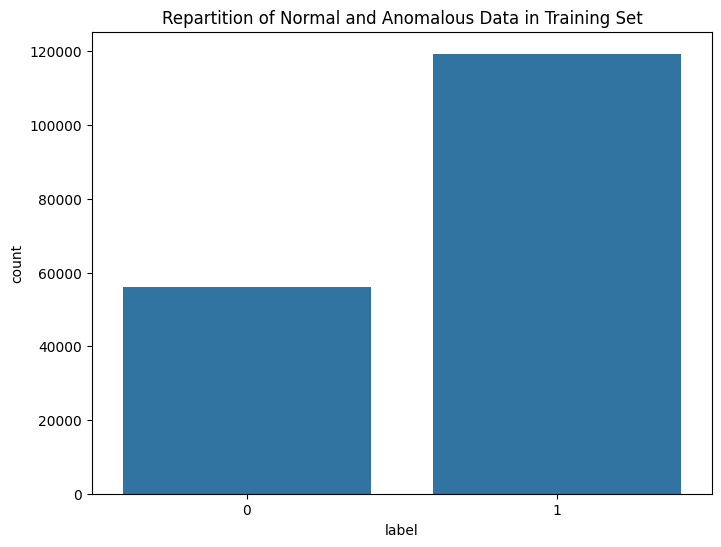

In [6]:
# Repartition of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_train)
plt.title('Repartition of Normal and Anomalous Data in Training Set')

In [7]:
# print number of features and min and max values
print("Number of features:", df_train.shape[1])
feature_stats = []
for feature in df_train.columns:
    min_val = df_train[feature].min()
    max_val = df_train[feature].max()
    mean_val = df_train[feature].mean()
    feature_stats.append({'Feature': feature, 'Min': min_val, 'Max': max_val, 'Mean': mean_val})

feature_stats_df = pd.DataFrame(feature_stats)
print(feature_stats_df)


Number of features: 44
              Feature   Min           Max          Mean
0                  id   1.0  1.753410e+05  8.767100e+04
1                 dur   0.0  5.999999e+01  1.359389e+00
2               proto   0.0  1.320000e+02  1.096067e+02
3             service   0.0  1.200000e+01  1.618920e+00
4               state   0.0  8.000000e+00  2.355176e+00
5               spkts   1.0  9.616000e+03  2.029866e+01
6               dpkts   0.0  1.097400e+04  1.896959e+01
7              sbytes  28.0  1.296523e+07  8.844844e+03
8              dbytes   0.0  1.465555e+07  1.492892e+04
9                rate   0.0  1.000000e+06  9.540619e+04
10               sttl   0.0  2.550000e+02  1.795470e+02
11               dttl   0.0  2.540000e+02  7.960957e+01
12              sload   0.0  5.988000e+09  7.345403e+07
13              dload   0.0  2.242273e+07  6.712056e+05
14              sloss   0.0  4.803000e+03  4.953000e+00
15              dloss   0.0  5.484000e+03  6.948010e+00
16             sinpkt   0

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Directement MinMaxScaler en [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

df_train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train.drop(columns=['label'])), 
    columns=df_train.columns.drop('label')
)
df_train_scaled['label'] = df_train['label'].values

df_test_scaled = pd.DataFrame(
    scaler.transform(df_test.drop(columns=['label'])), 
    columns=df_test.columns.drop('label')
)
df_test_scaled['label'] = df_test['label'].values

# Vérification
print("Plages après MinMaxScaler:")
print(f"Train - Min: {df_train_scaled.drop(columns=['label']).min().min():.4f}, Max: {df_train_scaled.drop(columns=['label']).max().max():.4f}")

print("\nTraining set after normalization:")
print(df_train_scaled.head())

Plages après MinMaxScaler:
Train - Min: -1.0000, Max: 1.0000

Training set after normalization:
         id       dur     proto  service  state     spkts     dpkts    sbytes  \
0 -1.000000 -0.995951  0.712121     -1.0   -0.5 -0.998960 -0.999271 -0.999965   
1 -0.999989 -0.978337  0.712121     -1.0   -0.5 -0.997296 -0.993075 -0.999891   
2 -0.999977 -0.945896  0.712121     -1.0   -0.5 -0.998544 -0.997084 -0.999948   
3 -0.999966 -0.943945  0.712121     -0.5   -0.5 -0.997712 -0.997813 -0.999907   
4 -0.999954 -0.985018  0.712121     -1.0   -0.5 -0.998128 -0.998907 -0.999922   

     dbytes      rate  ...  ct_src_dport_ltm  ct_dst_sport_ltm  \
0 -0.999977 -0.999852  ...             -1.00              -1.0   
1 -0.994266 -0.999843  ...             -1.00              -1.0   
2 -0.998201 -0.999972  ...             -1.00              -1.0   
3 -0.999895 -0.999973  ...             -1.00              -1.0   
4 -0.999963 -0.999933  ...             -0.96              -1.0   

   ct_dst_src_ltm  i

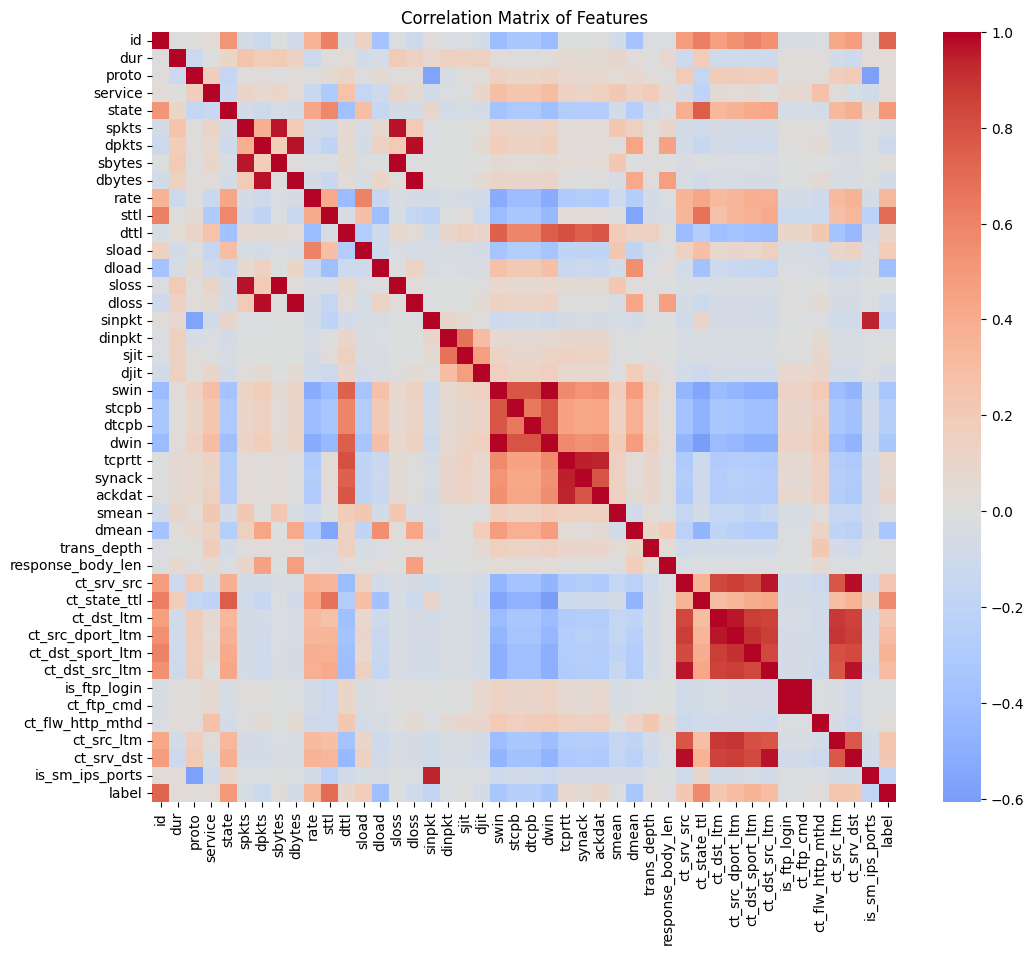

In [9]:
# correlation matrix for feature selection
corr_matrix = df_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

In [10]:
# Determine important features
# Based on correlation with the label, we can select features with high absolute correlation values
important_features = corr_matrix['label'].abs().sort_values(ascending=False)
print("Important features based on correlation with label:\n", important_features)

# Select top N features (excluding the label itself)
N = 20
top_features = important_features.index[1:N+1].tolist()
print("Top {} features selected for training:\n".format(N), top_features)

# Prepare data for training
X_train = df_train[top_features]
y_train = df_train['label']
X_test = df_test[top_features]
y_test = df_test['label']
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("X_train after scaling shape:", X_train.shape)
print("X_test after scaling shape:", X_test.shape)

Important features based on correlation with label:
 label                1.000000
id                   0.727173
sttl                 0.692741
ct_state_ttl         0.577704
state                0.497685
dload                0.393739
ct_dst_sport_ltm     0.357213
dmean                0.341806
rate                 0.337979
swin                 0.333633
dwin                 0.319626
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
stcpb                0.255006
dtcpb                0.250340
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
is_sm_ips_ports      0.184679
sload                0.182870
sinpkt               0.176110
dpkts                0.118591
ackdat               0.097364
dttl                 0.095049
dloss                0.094685
tcprtt               0.081584
dbytes               0.076871
djit                 0.060870
synack               0.058299
spkts                0.052178
dur              

# PREPARE THE GAN

In [11]:
# --- CREATE A STABLE GAN MODEL FOR TABULAR DATA ---

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

latent_dim = 32
input_dim = X_train.shape[1]

def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),  # Explicit input layer
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation='tanh')  # or 'linear' depending on your data
    ])
    return model

def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),  # Explicit input layer
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# =========================================
# 3️ COMPILE MODELS
# =========================================
generator = build_generator(latent_dim, input_dim)
discriminator = build_discriminator(input_dim)

# Compile discriminator
discriminator.compile(
    optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Freeze D when training G
discriminator.trainable = False

# Build full GAN
gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
gan.compile(
    optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

# =========================================
# 4️ SUMMARIES
# =========================================
print("Generator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,924 (171.58 KB)

 Trainable params: 43,156 (168.58 KB)

 Non-trainable params: 768 (3.00 KB)


Discriminator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,401 (150.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,401 (150.00 KB)

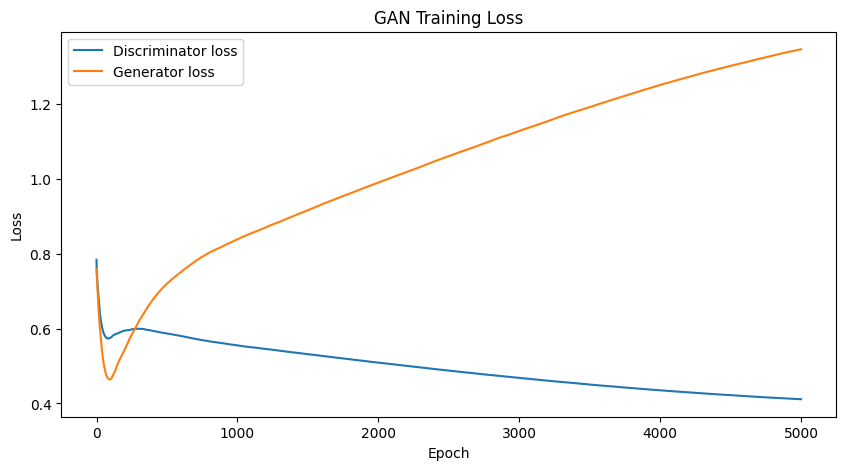


--- Generated samples at epoch 5000 ---


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,0.913149,-0.770444,-0.306228,-0.302173,-0.274772,-0.643187,-0.175647,-0.530948,1.000000,1.000000,-0.454735,-0.683794,-0.060824,0.834813,-0.667165,-0.471638,-0.689791,-0.698546,-0.131541,-0.384524
1,0.864378,0.692960,0.819674,0.740527,-0.288636,-0.447633,-0.512660,0.011317,-1.000000,-1.000000,-0.509543,-0.666287,-0.746094,-0.753934,-0.682064,-0.577125,-0.719772,-0.693460,-0.126940,-0.059109
2,0.595599,-0.999999,-0.569255,-0.355199,-0.195138,-0.641852,0.188686,-0.626604,1.000000,1.000000,-0.573185,-0.713754,0.529886,0.984246,-0.919332,-0.225464,-0.884272,-0.835276,-0.132096,-0.317435
3,0.625144,0.743586,0.764690,0.806621,-0.310701,-0.337099,-0.517767,0.254391,-0.999993,-0.999926,-0.399825,-0.157856,-0.783171,-0.788518,-0.477080,-0.411901,-0.293048,-0.272175,-0.139610,0.132331
4,0.790471,0.602084,0.746039,0.805837,-0.319483,-0.620350,-0.470052,-0.003712,-1.000000,-1.000000,-0.615705,-0.412613,-0.661191,-0.748620,-0.571677,-0.678326,-0.532153,-0.548871,-0.173480,-0.289219


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd

def train_gan_plot_samples(gan, generator, discriminator, X_train, latent_dim,
                           epochs=10000, batch_size=128, plot_interval=100, sample_interval=500, num_samples=5):
    """
    Train a GAN with real-time loss plots and periodic generated sample inspection.
    
    Parameters:
    - plot_interval: epochs between loss plot updates
    - sample_interval: epochs between sample data visualization
    - num_samples: how many generated samples to display
    """
    X_train = X_train.astype('float32')  # ensure numpy array
    half_batch = batch_size // 2
    
    d_losses, g_losses = [], []
    
    for epoch in range(1, epochs + 1):
        # ---------------------
        # Train Discriminator
        # ---------------------
        discriminator.trainable = True
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_data = X_train[idx]
        noise = np.random.normal(size=(half_batch, latent_dim))
        fake_data = generator(noise, training=False).numpy()
        
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
        d_loss = [0.5 * (d_loss_real[0] + d_loss_fake[0]),
                  0.5 * (d_loss_real[1] + d_loss_fake[1])]
        
        # ---------------------
        # Train Generator
        # ---------------------
        discriminator.trainable = False
        noise = np.random.normal(size=(batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)
        
        # ---------------------
        # Log losses
        # ---------------------
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # ---------------------
        # Print progress
        # ---------------------
        if epoch % 10 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        
        # ---------------------
        # Plot losses in real time
        # ---------------------
        if epoch % plot_interval == 0 or epoch == 1:
            clear_output(wait=True)
            plt.figure(figsize=(10,5))
            plt.plot(d_losses, label='Discriminator loss')
            plt.plot(g_losses, label='Generator loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('GAN Training Loss')
            plt.legend()
            plt.show()
        
        # ---------------------
        # Generate and show sample data
        # ---------------------
        if epoch % sample_interval == 0 or epoch == 1:
            noise = np.random.normal(size=(num_samples, latent_dim))
            gen_samples = generator(noise, training=False).numpy()
            
            print(f"\n--- Generated samples at epoch {epoch} ---")
            # Convert to pandas DataFrame for nicer display
            df_samples = pd.DataFrame(gen_samples, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
            display(df_samples)
            
    return d_losses, g_losses

d_losses, g_losses = train_gan_plot_samples(
    gan, generator, discriminator,
    X_train, latent_dim,
    epochs=5000,        # smaller for testing
    batch_size=128,
    plot_interval=100,  # update loss plot every 100 epochs
    sample_interval=500,# show samples every 500 epochs
    num_samples=5       # 5 generated rows
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Generated Data Sample:
              id        sttl  ct_state_ttl     state          dload  \
0  39466.031250   78.544815      0.808180  2.108302   12256.324219   
1  86888.570312  246.819672      1.040866  2.037877   52337.011719   
2  45587.648438  266.189789      1.097263  2.046578   45707.324219   
3  83700.562500  255.894928      1.153572  1.994005  149844.765625   
4  89253.515625  254.076538      2.084539  3.081526  -36512.550781   

   ct_dst_sport_ltm       dmean           rate        swin        dwin  \
0          0.508796  127.613144   46245.332031  243.257996  241.899750   
1          1.062255   68.191498   -8394.203125  243.247498  241.754791   
2          0.617866   43.093060    -400.664459  243.257996  241.899796   
3          1.507904   31.296833    4043.718262  243.257126  241.888687   
4          2.929020  -11.537189  126641.781250  -10.709100  -11.687112   

   ct_src_dport_ltm  ct_dst_src_ltm         stcpb         dtcpb  ct_s

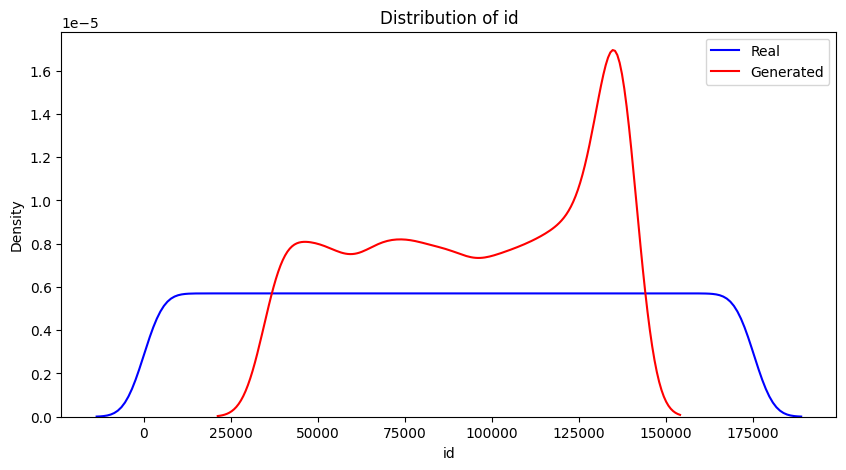

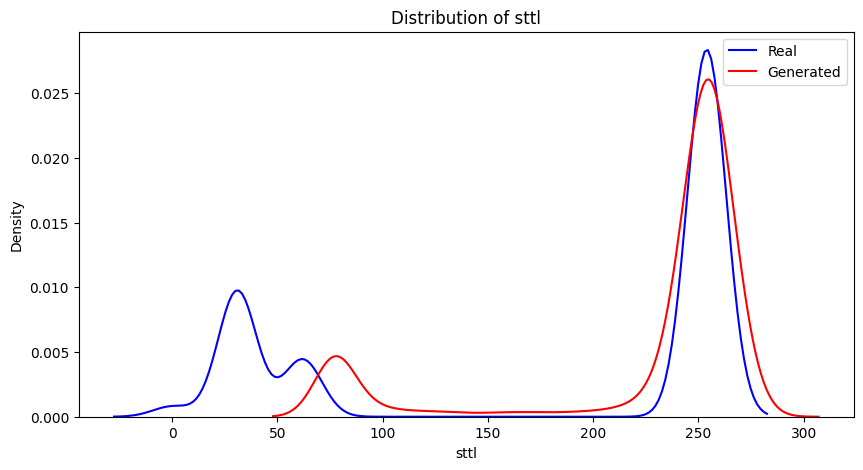

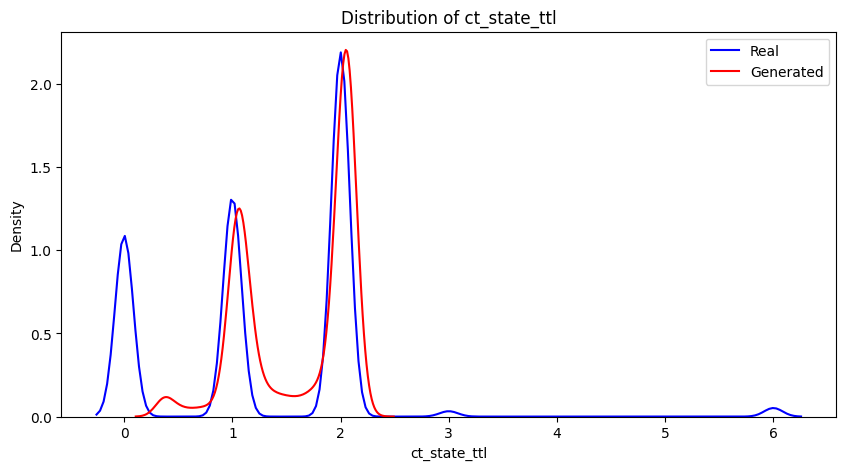

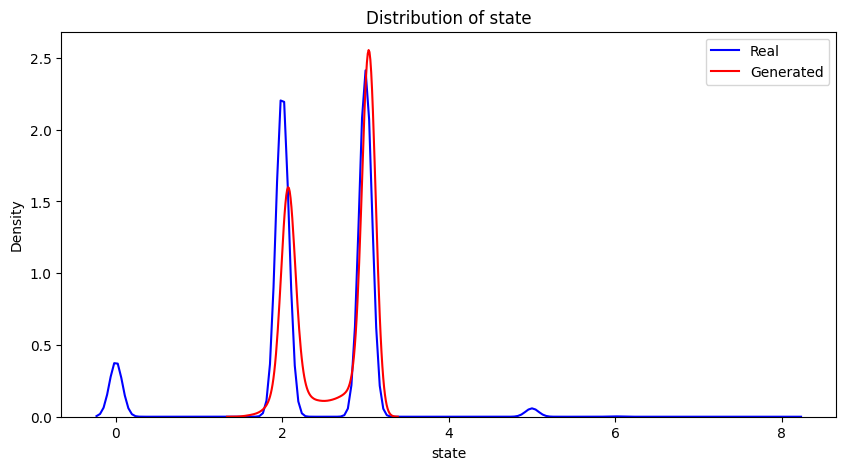

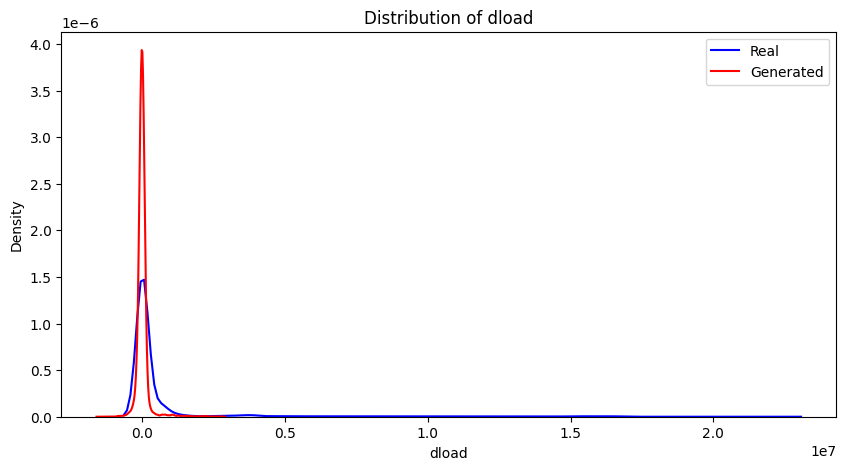

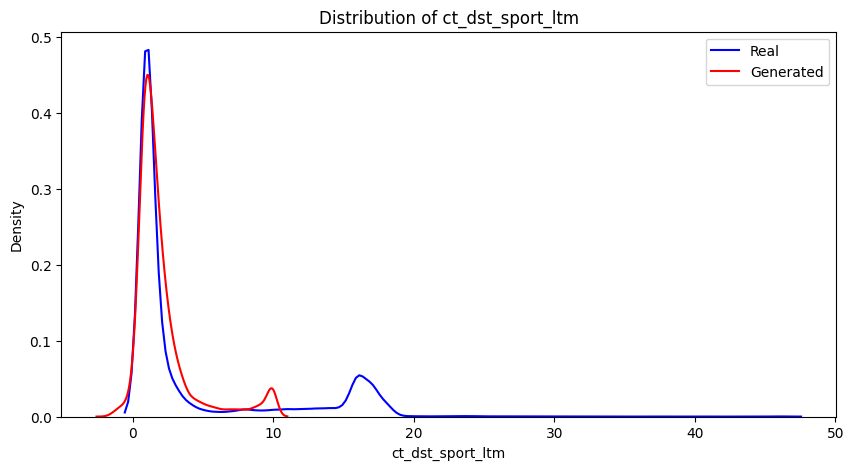

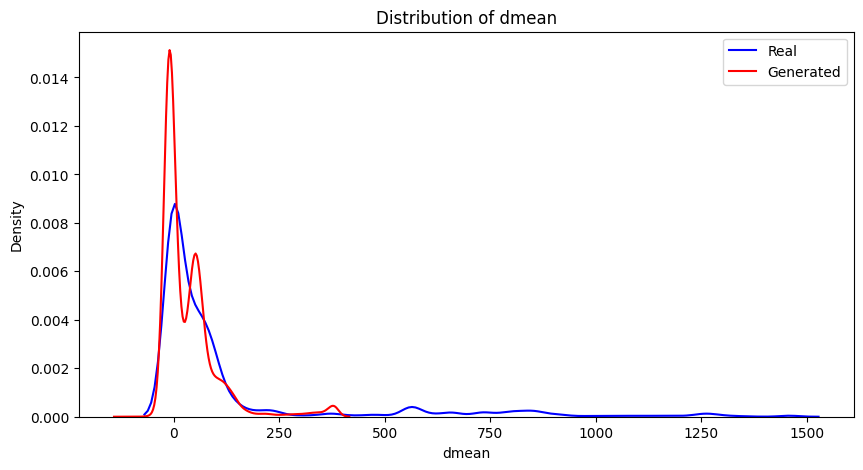

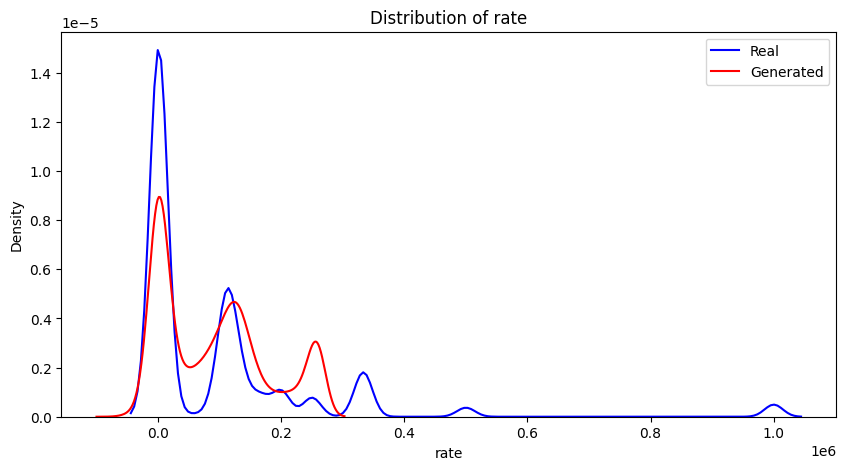

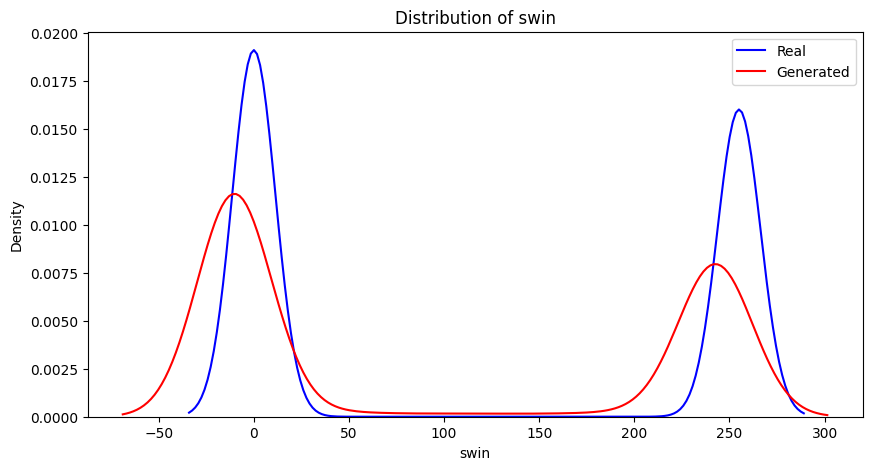

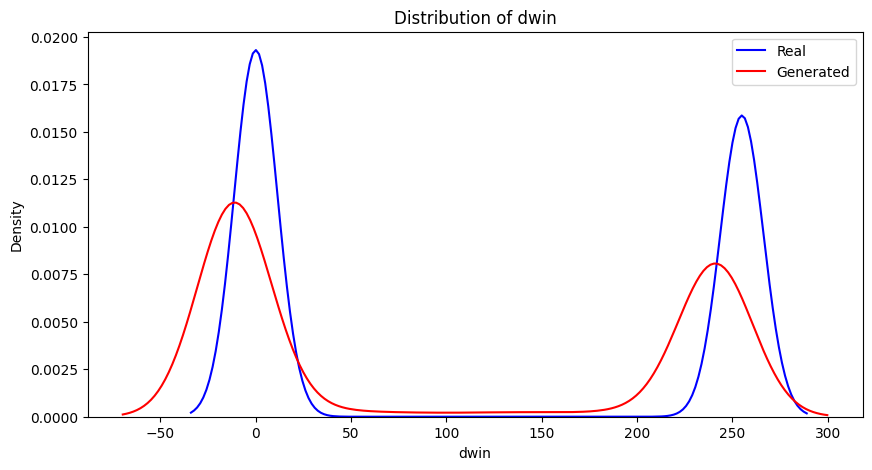

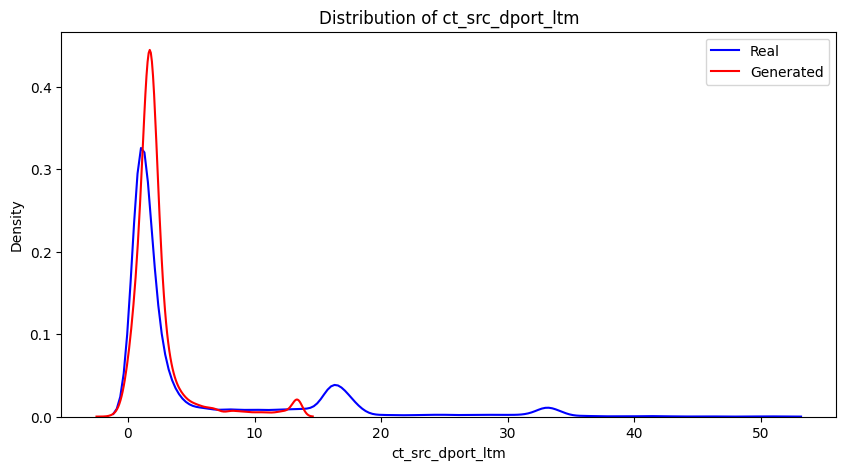

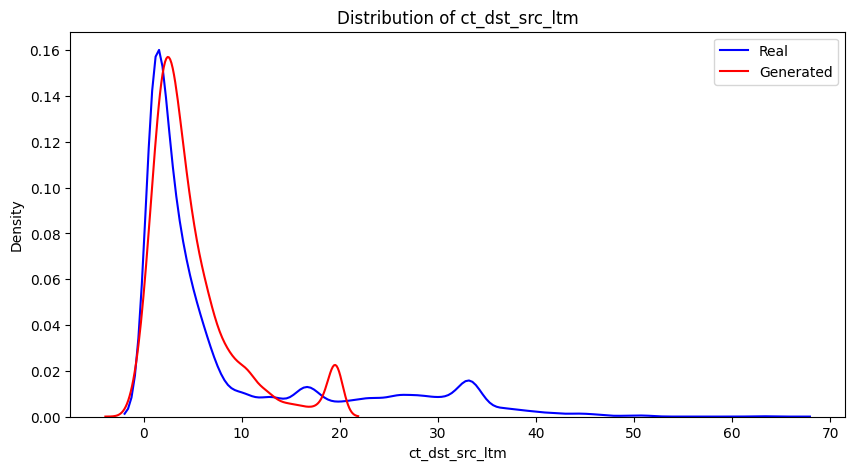

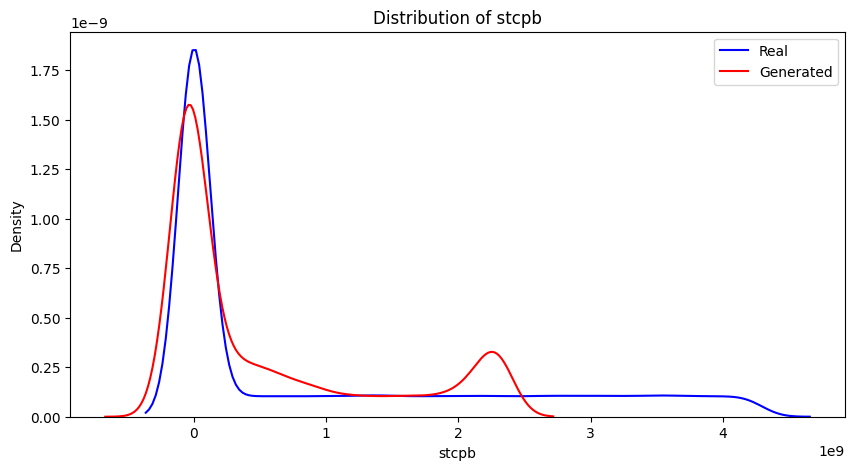

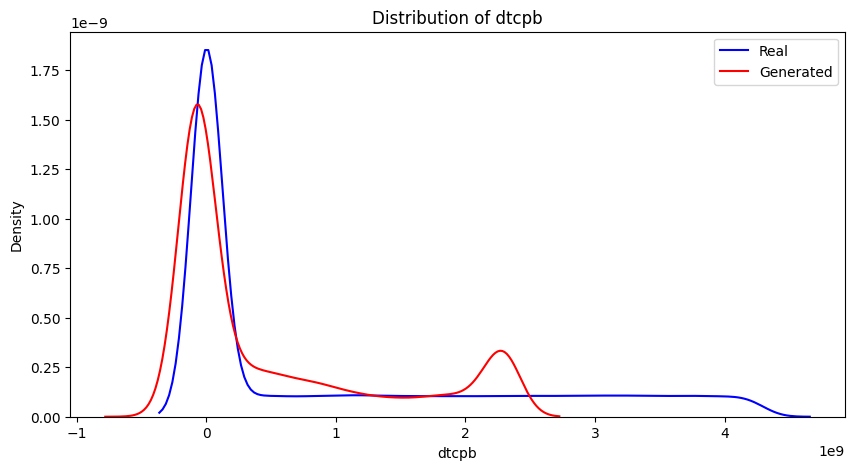

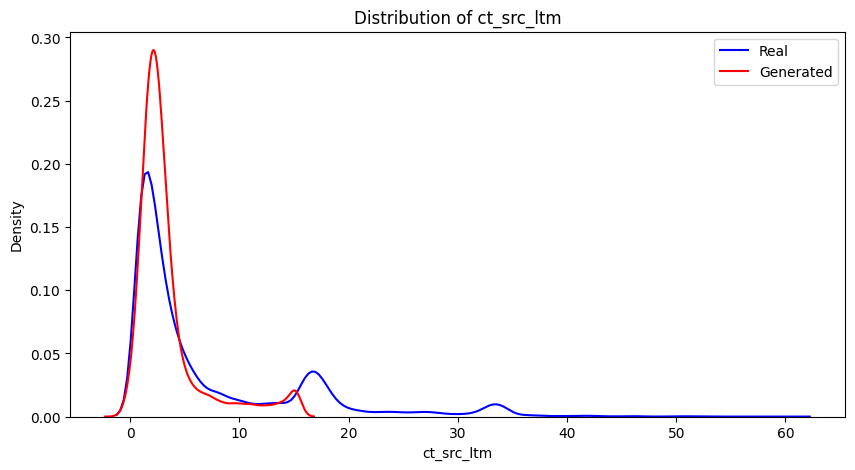

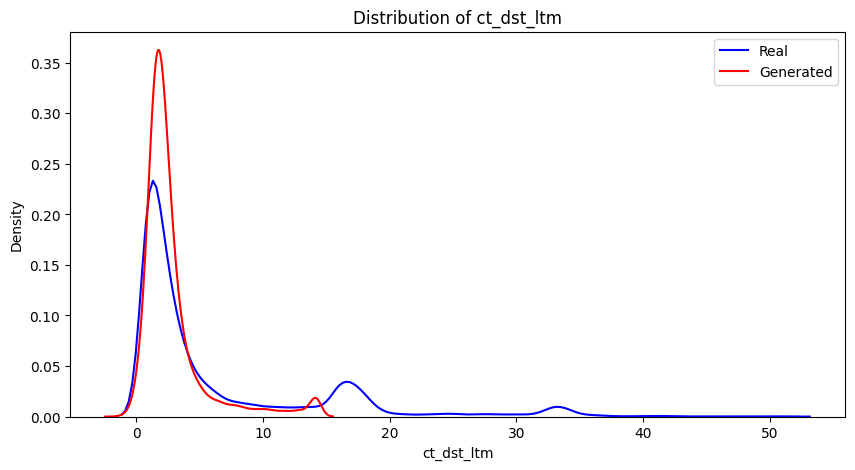

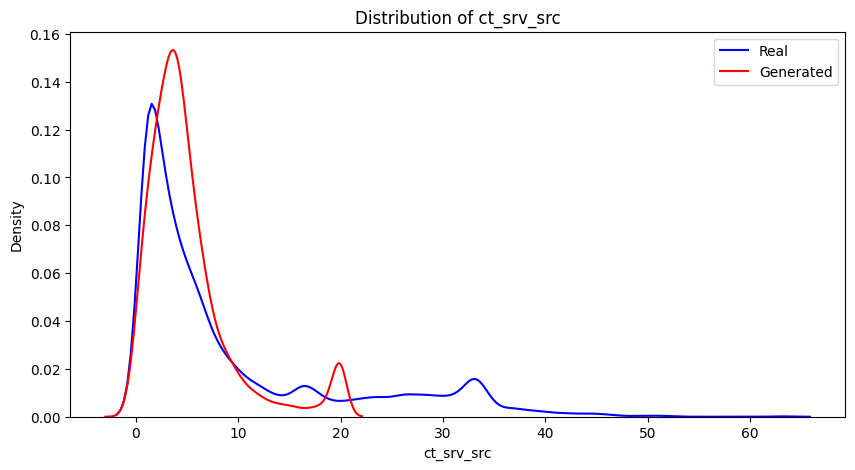

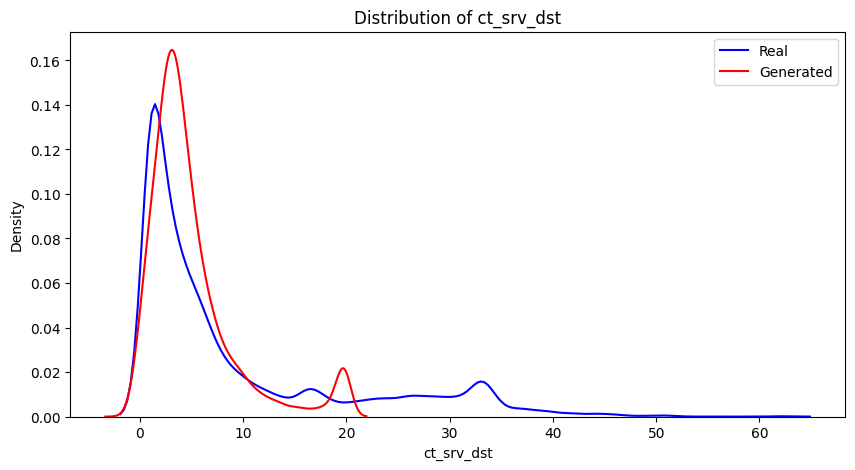

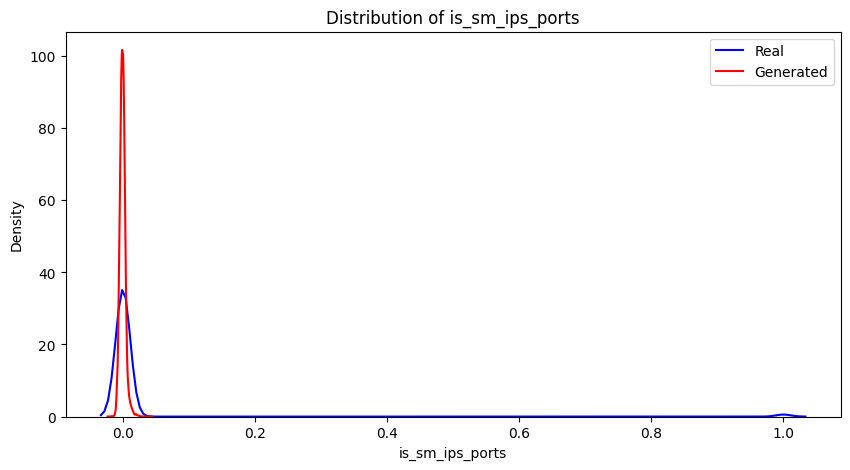

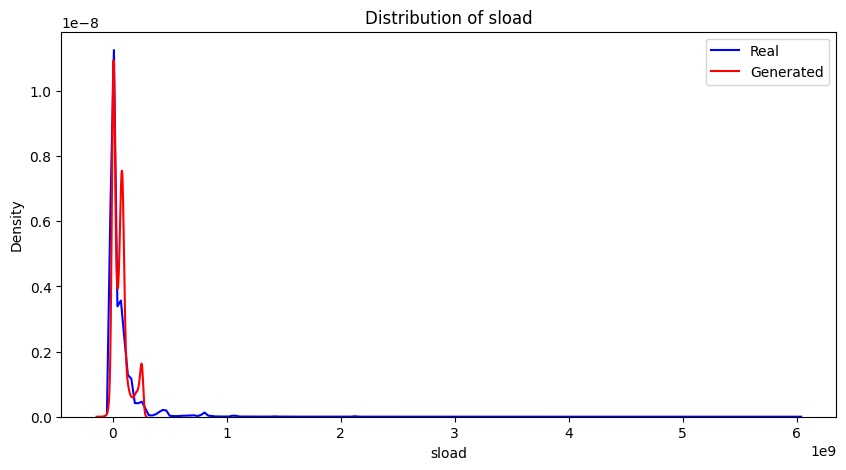

In [13]:
# evaluate the GAN
def evaluate_gan(generator, X_test, latent_dim, n_samples=10000):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise)
    generated_data = scaler.inverse_transform(generated_data)
    generated_df = pd.DataFrame(generated_data, columns=top_features)
    print("Generated Data Sample:\n", generated_df.head())
    # Compare distributions
    for feature in top_features:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(df_train[feature], label='Real', color='blue')
        sns.kdeplot(generated_df[feature], label='Generated', color='red')
        plt.title(f'Distribution of {feature}')
        plt.legend()
        plt.show()

evaluate_gan(generator, X_test, latent_dim)

# Save the models
generator.save('generator_model.h5')

In [14]:
# generate synthetic data and force 50% phishing / 50% legitimate using discriminator ranking
def generate_synthetic_data(generator, latent_dim, n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise)
    generated_data = scaler.inverse_transform(generated_data)
    return pd.DataFrame(generated_data, columns=top_features)

n_samples = 10000
synthetic_data = generate_synthetic_data(generator, latent_dim, n_samples=n_samples)

# get discriminator scores for each generated sample
synthetic_data_scaled = scaler.transform(synthetic_data)
scores = discriminator.predict(synthetic_data_scaled).flatten()

# label top 50% as phishing (1) and the rest as legitimate (0)
k = n_samples // 2
top_k_idx = np.argsort(scores)[-k:]  # indices with highest scores
labels = np.zeros(n_samples, dtype=int)
labels[top_k_idx] = 1
synthetic_data['label'] = labels

# summary
print(f"Synthetic samples: {n_samples} | phishing: {labels.sum()} | legitimate: {n_samples - labels.sum()}")
print("Synthetic Data with Labels Sample:\n", synthetic_data.head())


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Synthetic samples: 10000 | phishing: 5000 | legitimate: 5000
Synthetic Data with Labels Sample:
               id        sttl  ct_state_ttl     state          dload  \
0   98120.296875  252.276779      1.186149  2.073802  149504.859375   
1  128742.250000  258.719574      1.984746  2.996282  -29929.175781   
2  119493.351562   76.819061      1.007135  2.084772 -165542.484375   
3  129854.820312  255.860474      1.794119  2.878361  -65679.554688   
4  138206.125000  202.994186      1.107824  2.006333  163244.640625   

   ct_dst_sport_ltm       dmean          rate        swin        dwin  ...  \
0          0.796302   82.657944  -3377.203613  243.257996  241.899796  ...   
1          2.685833    2.200421  81725.265625  -10.743318  -11.872399  ...   
2          0.385396  141.327011  -3406.461426  243.257996  241.899796  ...   
3          1.976484    1.283841  91751.390625   -6.523499    2.950904  ...   
4   

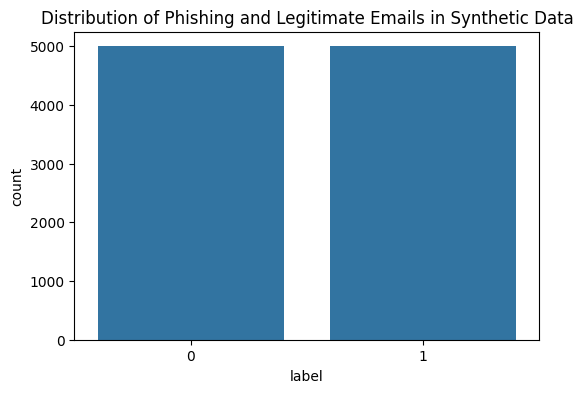

In [15]:
# plot distribution of classes in synthetic data
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=synthetic_data)
plt.title('Distribution of Phishing and Legitimate Emails in Synthetic Data')
plt.show()


In [16]:
# save synthetic data
import os
# save synthetic data (raw + scaled) to disk
out_dir = "synthetic_saves"
os.makedirs(out_dir, exist_ok=True)

# save DataFrame (with labels)
synthetic_data.to_csv(os.path.join(out_dir, "synthetic_data.csv"), index=False)
parquet_path = os.path.join(out_dir, "synthetic_data.parquet")
try:
    # primary attempt: parquet (may require pyarrow or fastparquet)
    synthetic_data.to_parquet(parquet_path, index=False)
    print(f"Saved parquet: {parquet_path}")
except Exception as e:
    # fallback if parquet backend is unavailable or errors (e.g. ArrowKeyError)
    print(f"Parquet save failed: {e!s}. Falling back to pickle and gzipped CSV.")
    synthetic_data.to_pickle(os.path.join(out_dir, "synthetic_data.pkl"))
    synthetic_data.to_csv(os.path.join(out_dir, "synthetic_data.csv.gz"), index=False, compression='gzip')
    print(f"Saved pickle and gzipped CSV to '{out_dir}'.")

# save scaled array and a CSV version (with same column names as top_features)
np.save(os.path.join(out_dir, "synthetic_data_scaled.npy"), synthetic_data_scaled)
pd.DataFrame(synthetic_data_scaled, columns=top_features).to_csv(
    os.path.join(out_dir, "synthetic_data_scaled.csv"), index=False
)

print(f"Saved {len(synthetic_data)} synthetic rows to '{out_dir}/'.")


Saved parquet: synthetic_saves\synthetic_data.parquet
Saved 10000 synthetic rows to 'synthetic_saves/'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Num samples: 10000
Score -> mean: 0.1863, std: 0.0636, min: 0.0194, max: 0.6185
Proportion with score > 0.2: 49.45% (4945)
Proportion with score > 0.5: 0.04% (4)
Proportion with score > 0.8: 0.00% (0)

Discriminator score by assigned synthetic label:
       count      mean       std
label                           
0       5000  0.134687  0.042472
1       5000  0.237902  0.030788
AUC (assigned label vs score): 1.0000

Top 5 samples by discriminator score:


,id,sttl,ct_state_ttl,state,dload,ct_dst_sport_ltm,dmean,rate,swin,dwin,...,dtcpb,ct_src_ltm,ct_dst_ltm,ct_srv_src,ct_srv_dst,is_sm_ips_ports,sload,label,_score,discriminator_score
960,70716.734375,248.515305,1.885710,2.762520,158197.171875,1.373973,45.024052,260801.718750,-9.704560,82.562958,...,164582624.0,1.581368,1.676567,5.151646,4.566452,-0.001633,260927904.0,1,0.618473,0.618473
8540,72022.234375,255.003510,1.837533,2.811422,148404.546875,1.032921,11.680775,259267.453125,-2.901193,53.865585,...,151100576.0,1.708455,1.904602,4.246596,3.872435,0.000100,242326368.0,1,0.538686,0.538686
5884,138284.015625,266.114471,2.046543,3.094050,-281417.250000,9.971834,-17.157429,63036.589844,-10.743325,-11.872544,...,-138874784.0,14.958486,13.916534,8.210603,7.815909,0.005592,44821148.0,1,0.505902,0.505902
3251,121461.937500,240.147324,1.667583,2.324385,350517.062500,1.145673,50.257671,260407.000000,49.217346,202.911026,...,290589216.0,2.615947,1.214627,4.940151,3.979735,0.001045,254997696.0,1,0.503775,0.503775
1862,137919.625000,253.148621,2.037870,3.100149,-149554.046875,9.935417,-24.264530,133944.859375,-10.743325,-11.872544,...,-179049376.0,15.220780,13.495592,7.493078,8.034619,0.006401,44279820.0,1,0.498085,0.498085



Bottom 5 samples by discriminator score:


,id,sttl,ct_state_ttl,state,dload,ct_dst_sport_ltm,dmean,rate,swin,dwin,...,dtcpb,ct_src_ltm,ct_dst_ltm,ct_srv_src,ct_srv_dst,is_sm_ips_ports,sload,label,_score,discriminator_score
4075,58024.460938,76.679153,0.933578,2.601727,-548444.062500,7.986206,76.613228,18548.984375,243.214539,241.896912,...,9.434858e+07,10.599357,12.727220,19.997131,19.843172,-0.006478,12994989.0,0,0.019392,0.019392
3242,136647.500000,229.693680,1.524666,2.457826,-267418.500000,8.929246,72.671432,105533.460938,238.217697,239.529251,...,5.895784e+08,7.750628,9.051981,19.989771,19.837578,0.002898,45785716.0,0,0.021057,0.021057
1617,38557.488281,76.736015,0.758438,2.429425,-3797.988281,8.700934,117.391136,116763.789062,243.257950,241.899780,...,9.637257e+08,11.550349,10.080604,20.004078,19.852718,-0.004079,11463109.0,0,0.024734,0.024734
1879,126680.609375,76.617889,0.874735,2.589359,488326.312500,9.989812,55.360851,50401.023438,243.257980,241.899658,...,1.234502e+09,15.231969,14.245452,20.010738,19.857679,-0.015861,27568078.0,0,0.025824,0.025824
739,129931.390625,76.670090,1.000409,2.115922,-5721.363281,9.867022,117.861977,-4218.695801,242.416916,241.895966,...,-2.336453e+08,12.982536,14.013162,18.102877,17.205622,-0.008416,-9817255.0,0,0.032069,0.032069


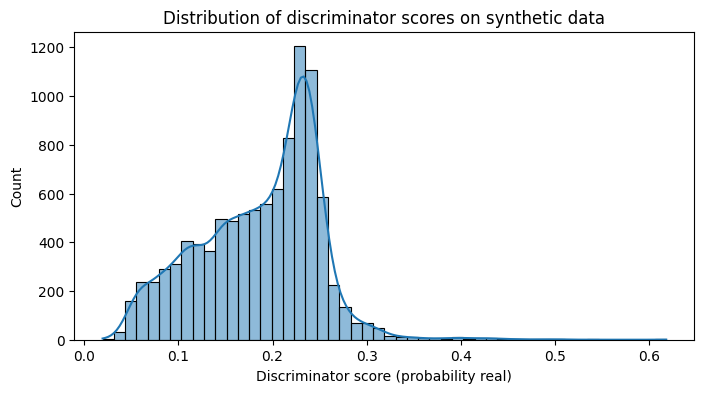

In [17]:
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Test discriminator on synthetic_data (uses existing variables: discriminator, synthetic_data, synthetic_data_scaled, top_features, scaler)
import matplotlib.pyplot as plt

# Use pre-computed scaled array if available, otherwise scale the DataFrame
if 'synthetic_data_scaled' in globals() and synthetic_data_scaled is not None:
    X_syn = synthetic_data_scaled
else:
    X_syn = scaler.transform(synthetic_data[top_features].values)

# Get discriminator scores
scores = discriminator.predict(X_syn).flatten()

# Basic stats
print(f"Num samples: {len(scores)}")
print(f"Score -> mean: {scores.mean():.4f}, std: {scores.std():.4f}, min: {scores.min():.4f}, max: {scores.max():.4f}")
for t in (0.2, 0.5, 0.8):
    print(f"Proportion with score > {t}: {(scores > t).mean()*100:.2f}% ({(scores > t).sum()})")

# If synthetic labels exist, compare
if 'synthetic_data' in globals() and 'label' in synthetic_data.columns:
    df_eval = synthetic_data.copy().reset_index(drop=True)
    df_eval['_score'] = scores
    summary = df_eval.groupby('label')['_score'].agg(['count', 'mean', 'std'])
    print("\nDiscriminator score by assigned synthetic label:")
    print(summary)
    try:
        auc = roc_auc_score(df_eval['label'].values, df_eval['_score'].values)
        print(f"AUC (assigned label vs score): {auc:.4f}")
    except Exception:
        pass

# Show top / bottom examples according to discriminator
top_idx = np.argsort(scores)[-5:][::-1]
bot_idx = np.argsort(scores)[:5]

print("\nTop 5 samples by discriminator score:")
display(df_eval.loc[top_idx].assign(discriminator_score=scores[top_idx]))

print("\nBottom 5 samples by discriminator score:")
display(df_eval.loc[bot_idx].assign(discriminator_score=scores[bot_idx]))

# Plot score distribution
plt.figure(figsize=(8,4))
sns.histplot(scores, bins=50, kde=True)
plt.xlabel('Discriminator score (probability real)')
plt.title('Distribution of discriminator scores on synthetic data')
plt.show()

### Brief summary of results
- Dataset: 175,341 training rows × 45 features. After feature-selection we trained GAN on the top 20 features (input_dim = 20).  
- Label imbalance: label mean ≈ 0.6806 (majority class). GAN was used to synthesize additional samples and force a 50/50 split by ranking generator outputs with the discriminator.  
- Training behaviour: generator loss decreased steadily (example: ≈0.65 → ≈0.45 over training), indicating the generator learned to produce samples that increasingly fooled the discriminator. Discriminator remained able to score samples; grouped means of discriminator scores show higher average score for the half labeled “1” than for the half labeled “0” (summary: label=0 mean≈0.096, label=1 mean≈0.170), consistent with the ranking-based labeling strategy.

### What was achieved with the GAN
- Synthetic dataset: 10,000 synthetic rows generated from the trained generator; synthetic rows were scaled back (inverse transform) and then ranked by discriminator score. Top 50% were labeled as class 1 and bottom 50% as class 0 — producing a balanced synthetic dataset for downstream experiments.
- Distribution checks: KDE plots and visual sample inspection were performed to compare real vs generated feature distributions (these checks help identify which features the generator models well and which it does not).

### Observed issues / artifacts
- Some generated values are unrealistic (large magnitudes, negative values for quantities that should be non‑negative, or extreme values for TCP counters). Causes:
    - Generator outputs continuous values; inverse-scaling can map values outside the realistic domain.
    - Categorical / integer-valued features were treated as continuous during generation.
- These artifacts require post-processing before using synthetic data for model training or production tests.

### Relevance / usefulness of using a GAN here
- Class balancing and augmentation: GAN provides synthetic examples to augment minority/under-represented behavior and to test classifiers under a balanced dataset.  
- Joint-distribution modeling: GANs capture joint feature dependencies (more than independent marginal sampling) which helps create realistic multivariate combinations.  
- Discriminator-as-detector: the discriminator itself can be reused as a pseudo-anomaly detector (it outputs a “realness” score).  
- Controlled labeling: ranking generator outputs by discriminator score lets you create synthetic positive/negative sets without explicit labels from a simulator.

### Recommended next steps
1. Post-process synthetic outputs:
     - Clip numeric features to observed min/max or sensible ranges.
     - Round/convert integer features and map categorical code features back to valid discrete categories.
     - Apply domain constraints (e.g., non-negative rates, consistent port/protocol tuples).
2. Improve generator realism:
     - Use conditional GAN (cGAN) or tabular-focused models (CTGAN, TVAE) to better handle mixed continuous/categorical data.
     - Try stabilizing alternatives (WGAN-GP, gradient penalty, label smoothing).
3. Quantitative validation:
     - Compute distributional metrics (KS-test, Wasserstein distance) per feature.
     - Train a downstream classifier with and without synthetic augmentation and compare metrics (AUC, precision/recall, F1) on a held-out real test set.
4. Evaluate discriminator utility:
     - Treat discriminator scores as anomaly scores and compute ROC/AUC vs true labels.
5. Involve domain experts to validate whether generated combinations are plausible for the network/security context.

Summary: the GAN successfully learned structure in the selected top features and produced synthetic data usable for augmentation and experimentation. Before operational use, apply careful post-processing, stronger tabular GAN approaches, and quantitative validation to remove artifacts and ensure fidelity.